In [5]:
import os
cwd =  os.getcwd().replace("notebooks/research","")
os.chdir(cwd)

In [6]:
# --- Robust notebook shim for legacy joblib artifacts expecting `encoders.*` ---
import sys, types, numpy as np

# Create/replace a lightweight 'encoders' module in sys.modules
enc_mod = types.ModuleType("encoders")

try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    SentenceTransformer = None
    print("NOTE: sentence-transformers not available:", e)

class _SBERTBase:
    """
    Compat shim implementing the sklearn Transformer API expected by saved Pipelines.
    Handles pickles that don't call __init__ and are missing attributes.
    Provides both class names: SBERTEncoder and SBERTFeaturizer.
    """
    # NOTE: __init__ might not be called during unpickle; use _ensure_attrs() everywhere.
    def __init__(self, model="sentence-transformers/all-MiniLM-L6-v2", **kwargs):
        self.model_name = model
        self._enc = None
        self._kwargs = kwargs

    def _ensure_attrs(self):
        # Add any attributes that might be missing from legacy pickles
        if not hasattr(self, "model_name") or self.model_name is None:
            self.model_name = "sentence-transformers/all-MiniLM-L6-v2"
        if not hasattr(self, "_enc"):
            self._enc = None
        if not hasattr(self, "_kwargs"):
            self._kwargs = {}

    def _ensure_encoder(self):
        self._ensure_attrs()
        if self._enc is None:
            if SentenceTransformer is None:
                raise RuntimeError(
                    "sentence-transformers not installed in this kernel; "
                    "pip install sentence-transformers && restart kernel"
                )
            self._enc = SentenceTransformer(self.model_name)

    # sklearn API
    def fit(self, X, y=None):
        self._ensure_attrs()
        return self

    def transform(self, X):
        self._ensure_encoder()
        return np.asarray(self._enc.encode(list(X), show_progress_bar=False))

    # some older code may call .encode directly; alias it
    def encode(self, X):
        return self.transform(X)

# Expose both legacy names on the encoders module
class SBERTEncoder(_SBERTBase): ...
class SBERTFeaturizer(_SBERTBase): ...

enc_mod.SBERTEncoder = SBERTEncoder
enc_mod.SBERTFeaturizer = SBERTFeaturizer
sys.modules["encoders"] = enc_mod

# Make sure your package code is importable too (if needed)
import pathlib
if str(pathlib.Path("src").resolve()) not in sys.path:
    sys.path.append(str(pathlib.Path("src").resolve()))
print("encoders shim ready (SBERTEncoder + SBERTFeaturizer) and sys.path configured")

encoders shim ready (SBERTEncoder + SBERTFeaturizer) and sys.path configured


In [7]:
import joblib
from pathlib import Path

def load_mapper():
    for name in [".artifacts/arc_mapper.joblib"]:
        p = Path(name).resolve()
        if p.exists():
            print("Loading:", p.as_posix())
            return joblib.load(p.as_posix())
    raise FileNotFoundError("No mapper artifact found in .artifacts/")

mapper = load_mapper()
print(mapper)


Loading: /Users/ian_moore/repos/micro-lm/.artifacts/arc_mapper.joblib
Pipeline(steps=[('sbertencoder', <__main__.SBERTEncoder object at 0x10458dc30>),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LogisticRegression(C=8.0,
                                                                     class_weight='balanced',
                                                                     max_iter=2000,
                                                                     random_state=0),
                                        method='isotonic'))])


In [31]:
prompt = "flip the grid horizontally"
#prompt = "Rotate the grid 90 degrees clockwise, then flip it horizontally"
pred  = mapper.predict([prompt])[0]
probs = mapper.predict_proba([prompt])[0]
print("Predicted:", pred)
print("Top-3:", sorted(zip(mapper.classes_, probs), key=lambda t: t[1], reverse=True)[:3])

Predicted: flip_h
Top-3: [('flip_h', 0.9375), ('flip_v', 0.06250000000000001), ('rotate', 0.0)]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### WDD Doctrine

In [38]:
# === WDD–ARC (Tier-2, latent-space) : final cell ==============================================
# Uses your trained ARC mapper Pipeline (SBERT → classifier). No grid traces required.
# - Shortlists candidates from the mapper (plus text hints)
# - Builds latent paths toward per-class prototype directions
# - Forms per-family envelopes (rotate uses prob trace; flip/color use energy residual)
# - Runs matched-filter + dual gates (family-local), returns kept primitives & order

import numpy as np, json, math, warnings, os, re
from collections import defaultdict
from numpy.linalg import norm

# --------------------------- Config (edit if needed) ------------------------------------------
ARC_MAPPER_PATH = locals().get("ARC_MAPPER_PATH", ".artifacts/arc_mapper.joblib")
ARC_LABELS_CSV  = locals().get("ARC_LABELS_CSV",  "")  # optional: labeled CSV to build centroids
ARC_CLASS_NAMES = locals().get("ARC_CLASS_NAMES", [])  # optional static list; else inferred

# Latent-path + parser settings
TOP_K       = 3
TRACE_LEN   = 128
ALPHA_MAX   = 2.2
SMOOTH_WIN  = 9
NULL_SHIFTS = 64

# Bring-up family-local thresholds (tighten later)
F_TAU = {
    "flip":   {"tau_rel": 0.05, "tau_corr": 0.25, "z_abs": 0.5, "area": 0.0},
    "rotate": {"tau_rel": 0.05, "tau_corr": 0.20, "z_abs": 0.30, "area": 0.0},
    "color":  {"tau_rel": 0.05, "tau_corr": 0.20, "z_abs": 0.30, "area": 0.0},
    "other":  {"tau_rel": 0.05, "tau_corr": 0.25, "z_abs": 0.50, "area": 0.0},
}

# Canonical mini-templates (used only if coef_/centroids absent)
ARC_CANON = {
    "flip_h": "flip the grid horizontally",
    "flip_v": "flip the grid vertically",
    "rotate": "rotate the grid 90 degrees clockwise",
    "rot90":  "rotate the grid 90 degrees clockwise",
    "rotate_cw": "rotate the grid 90 degrees clockwise",
    "rotate_ccw": "rotate the grid 90 degrees counterclockwise",
    "color_map": "map blue cells to yellow",
    "recolor":   "recolor blue cells to yellow",
}

ARC_CLASS_NAMES = ["rotate", "flip_h", "flip_v", "recolor"] 

# --------------------------------- Helpers -----------------------------------------------------
def _normalize(v):
    v = np.asarray(v, float).reshape(-1)
    return v / (np.linalg.norm(v) + 1e-12)

def _unwrap_mapper(mapper):
    """Return (encoder_step, clf_step) from a sklearn Pipeline-like mapper."""
    enc = clf = None
    if hasattr(mapper, "named_steps"):
        steps = dict(mapper.named_steps)
        # guess encoder by capability & name
        for name, step in steps.items():
            if hasattr(step, "transform") and ("sbert" in str(step).lower() or "sentence" in str(step).lower()):
                enc = step; break
        clf = list(steps.values())[-1]
    else:
        # best-effort (non-pipeline)
        if hasattr(mapper, "transform"): enc = mapper
        if hasattr(mapper, "predict_proba") or hasattr(mapper, "decision_function"): clf = mapper
    # calibrated wrappers sometimes store base_estimator
    base = getattr(clf, "base_estimator", None)
    if base is not None:
        clf = base
    return enc, clf

def _get_classes(mapper):
    """
    Safely extract class names from the final estimator in the mapper pipeline.
    Handles numpy arrays and missing attributes; falls back to ARC_CLASS_NAMES.
    """
    classes = None

    # Try the last pipeline step first
    if hasattr(mapper, "named_steps"):
        last = list(mapper.named_steps.values())[-1]
        classes = getattr(last, "classes_", None)

    # Fallback: mapper itself
    if classes is None:
        classes = getattr(mapper, "classes_", None)

    # If still missing or empty, use configured fallback
    if classes is None or (hasattr(classes, "__len__") and len(classes) == 0):
        classes = ARC_CLASS_NAMES

    # Final sanity: must have something
    if classes is None or (hasattr(classes, "__len__") and len(classes) == 0):
        raise ValueError(
            "Could not infer class names from mapper. "
            "Set ARC_CLASS_NAMES to a non-empty list (e.g., "
            "['rotate','flip_h','flip_v','recolor'])."
        )

    # Convert numpy arrays to a Python list of strings
    if hasattr(classes, "tolist"):
        classes = classes.tolist()
    return [str(c) for c in classes]

def _embed_texts(mapper, texts):
    """Encode texts with the SBERT encoder inside the mapper; fallback to SentenceTransformer."""
    enc, _ = _unwrap_mapper(mapper)
    if enc is not None and hasattr(enc, "transform"):
        E = enc.transform(list(texts))
        return np.asarray(E)
    # fallback
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return np.asarray(model.encode(list(texts), normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False))

def _classifier_for_embed(mapper):
    """Return the last estimator (accepts embeddings). May be calibrated."""
    if hasattr(mapper, "named_steps"):
        return list(mapper.named_steps.values())[-1]
    return mapper

def _classifier_coef(clf):
    """Try to recover coef_ matrix from linear models or wrapped models."""
    co = getattr(clf, "coef_", None)
    if co is not None: return np.asarray(co, float)
    # calibrated form
    for attr in ("estimator_", "estimator", "base_estimator_", "base_estimator"):
        inner = getattr(clf, attr, None)
        if inner is not None and hasattr(inner, "coef_"):
            return np.asarray(inner.coef_, float)
    # OneVsRest
    if hasattr(clf, "estimators_"):
        rows = []
        for est in clf.estimators_:
            got = _classifier_coef(est)
            if got is None: return None
            rows.append(got.ravel())
        return np.vstack(rows) if rows else None
    # CalibratedClassifierCV (list of per-class calibrators)
    if hasattr(clf, "calibrated_classifiers_"):
        rows = []
        for cc in clf.calibrated_classifiers_:
            est = getattr(cc, "estimator", None)
            if est is not None and hasattr(est, "coef_"):
                rows.append(est.coef_.ravel())
        return np.vstack(rows) if rows else None
    return None

def _class_centroids_from_csv(mapper, labels_csv, class_names):
    """Optional: build SBERT centroids per class from a labeled CSV."""
    if not labels_csv or not os.path.exists(labels_csv): return None
    import pandas as pd
    df = pd.read_csv(labels_csv)
    if not {"prompt","label"}.issubset(df.columns): return None
    df = df.dropna(subset=["prompt","label"]).copy()
    df["prompt"] = df["prompt"].astype(str).str.strip()
    df["label"]  = df["label"].astype(str).str.strip()
    if df.empty: return None
    # embed in chunks
    B = 256; Es = []
    for i in range(0, len(df), B):
        Es.append(_embed_texts(mapper, df["prompt"].iloc[i:i+B].tolist()))
    X = np.vstack(Es)
    y = df["label"].tolist()
    cents = {}
    for c in class_names:
        idx = [i for i, yy in enumerate(y) if yy == c]
        if idx:
            m = X[idx].mean(axis=0)
            cents[c] = _normalize(m)
    return cents if cents else None

def _proto_directions(mapper, class_names):
    """Return dict label->unit direction. Try coef_, else CSV centroids, else canonical templates."""
    enc, clf = _unwrap_mapper(mapper)
    # 1) coef_
    co = _classifier_coef(clf)
    if co is not None:
        cls = getattr(clf, "classes_", class_names)
        cls = [str(c) for c in cls]
        P = {}
        for c in class_names:
            if c in cls:
                j = cls.index(c)
                P[c] = _normalize(co[j])
        if len(P) == len(class_names):
            return P
    # 2) centroids
    cents = _class_centroids_from_csv(mapper, ARC_LABELS_CSV, class_names)
    if cents:
        mu = _normalize(np.mean(np.vstack(list(cents.values())), axis=0))
        return {c: _normalize(cents[c] - mu) for c in class_names if c in cents}
    # 3) canonical templates
    T = [ARC_CANON.get(c, c) for c in class_names]
    E = _embed_texts(mapper, T)
    mu = _normalize(E.mean(axis=0))
    return {c: _normalize(E[i] - mu) for i, c in enumerate(class_names)}

def _half_sine_path(e0, p_hat, T=TRACE_LEN, alpha_max=ALPHA_MAX):
    p_hat = _normalize(p_hat)
    alphas = np.sin(np.linspace(0.0, np.pi, T)) * alpha_max
    return e0[None, :] + alphas[:, None] * p_hat[None, :]

def _smooth(x, w=SMOOTH_WIN):
    if w <= 1: return x
    k = np.ones(w, float) / float(w)
    return np.convolve(np.asarray(x, float), k, mode="same")

def _energies(Y, p, c=None):
    p = _normalize(p)
    D = Y.shape[1]
    if c is None: c = np.zeros(D, float)
    Z = Y - c[None, :]
    s = Z @ p
    E_par  = s**2
    E_tot  = np.sum(Z*Z, axis=1)
    E_perp = E_tot - E_par
    return _smooth(E_par), _smooth(E_perp)

def _nxcorr(env, q):
    env = np.asarray(env, float)
    q   = np.asarray(q, float)
    q   = (q - q.mean()); qn = np.linalg.norm(q) + 1e-12
    L   = len(q)
    pad = L // 2
    xx  = np.pad(env, (pad, pad), mode="edge")
    C   = np.zeros_like(env)
    for t in range(len(env)):
        seg = xx[t:t+L]; seg = seg - seg.mean()
        C[t] = float(np.dot(seg, q) / ((np.linalg.norm(seg) + 1e-12) * qn))
    return C

def _matched_filter_score(env):
    L = max(50, min(80, len(env)-4))
    t = np.arange(L)
    q = np.sin(np.pi * (t / (L-1)))
    C = _nxcorr(env, q)
    t_star = int(np.argmax(C))
    # half-max window
    xm = float(np.max(env)); half = 0.5 * xm
    a = t_star
    while a > 0 and env[a] > half: a -= 1
    b = t_star
    while b < len(env)-1 and env[b] > half: b += 1
    area = float(np.sum(env[max(0,a):min(len(env)-1,b)+1]))
    return float(C[t_star]), t_star, area, (int(a), int(b)), C

def _circular_shifts(x, K=NULL_SHIFTS):
    n = len(x)
    if n <= 2: return []
    shifts = np.random.choice(np.arange(1, n), size=min(K, n-1), replace=False)
    return [np.roll(x, s) for s in shifts]

def _absolute_null_z(env):
    nulls = _circular_shifts(env, NULL_SHIFTS)
    if not nulls: return 0.0
    peaks = [_matched_filter_score(ne)[0] for ne in nulls]
    mu, sd = float(np.mean(peaks)), float(np.std(peaks) + 1e-9)
    cm, *_ = _matched_filter_score(env)
    return (cm - mu) / sd

def _exclusive_residual(E_list):
    """Exclusive positive residual across siblings (QR projection; fallback to mean subtraction)."""
    if len(E_list) == 1:
        return [np.clip((E_list[0] - np.mean(E_list[0])) / (np.std(E_list[0]) + 1e-9), 0, None)]
    Z = np.vstack([ (e - np.mean(e)) / (np.std(e) + 1e-9) for e in E_list ])  # K x T
    Rex = []
    for k in range(Z.shape[0]):
        others = [j for j in range(Z.shape[0]) if j != k]
        A = Z[others].T  # T x (K-1)
        try:
            Q, _ = np.linalg.qr(A, mode="reduced")
            proj = Q @ (Q.T @ Z[k])
            ex = Z[k] - proj
        except Exception:
            ex = Z[k] - np.mean(Z[others], axis=0)
        Rex.append(np.clip(ex, 0, None))
    return Rex

def _family(lbl: str) -> str:
    s = lbl.lower()
    if s.startswith("flip_"):                 return "flip"
    if "rot" in s or s in {"rotate","rot90","rotate_cw","rotate_ccw"}: return "rotate"
    if s in {"recolor","color_map","color"}: return "color"
    return "other"

def _parse_hints(prompt: str):
    s = prompt.lower()
    want_flip   = ("flip" in s) or ("mirror" in s)
    want_rotate = ("rotate" in s) or ("cw" in s) or ("clockwise" in s) or ("counterclockwise" in s) or ("ccw" in s) or ("right" in s) or ("left" in s)
    want_color  = ("color" in s) or ("recolor" in s) or ("colour" in s) or ("recolour" in s) or ("map" in s)
    orient = None
    # add synonyms in _parse_hints
    if re.search(r"\b(hori(zontal)?|mirror\s*(left|right)|left\s*↔\s*right)\b", s): orient = "flip_h"
    elif re.search(r"\b(vert(ical)?|top\s*↕\s*bottom|up\s*down)\b", s): orient = "flip_v"
    return {"flip": want_flip, "rotate": want_rotate, "color": want_color}, orient

# --------------------------------- Main audit ---------------------------------
def wdd_arc_audit(prompt: str):
    import joblib
    mapper = joblib.load(ARC_MAPPER_PATH)
    class_names = _get_classes(mapper)

    # 0) text hints
    hints, orient_hint = _parse_hints(prompt)

    # 1) embed prompt (start point e0)
    e0 = _normalize(_embed_texts(mapper, [prompt])[0])

    # 2) mapper probabilities (for shortlist + tiny flip tie-break)
    if hasattr(mapper, "predict_proba"):
        probs = mapper.predict_proba([prompt])[0]
        smap  = {c: float(p) for c, p in zip(class_names, probs)}
    elif hasattr(mapper, "decision_function"):
        z = np.asarray(mapper.decision_function([prompt])[0], float).ravel()
        ex = np.exp(z - z.max()); pr = ex / (ex.sum() + 1e-12)
        smap = {c: float(p) for c, p in zip(class_names, pr)}
    else:
        pred = str(mapper.predict([prompt])[0])
        smap = {c: (1.0 if c==pred else 0.0) for c in class_names}
    mapper_top = max(smap.items(), key=lambda kv: kv[1])[0]

    # 3) route: text-gated shortlist
    MIN_CAND_PROB = 0.05     # tiny floor to consider a class from mapper
    STRICT_TEXT_GATING = True
    
    def _family(lbl: str) -> str:
        s = lbl.lower()
        if s.startswith("flip_"):                 return "flip"
        if "rot" in s or s in {"rotate","rot90","rotate_cw","rotate_ccw"}: return "rotate"
        if s in {"recolor","color_map","color"}:  return "color"
        return "other"
    
    # families explicitly mentioned in the prompt
    allowed_fams = set()
    if hints["flip"]:   allowed_fams.add("flip")
    if hints["rotate"]: allowed_fams.add("rotate")
    if hints["color"]:  allowed_fams.add("color")
    
    # base set: keep top-k classes with non-trivial probability
    topk = sorted(smap.items(), key=lambda kv: kv[1], reverse=True)[:max(1, TOP_K)]
    base = {c for c, p in topk if p >= MIN_CAND_PROB}
    base.add(mapper_top)  # always include mapper top-1
    
    # text inclusions: make sure families explicitly requested are represented
    text_added = set()
    for fam in allowed_fams:
        for c in class_names:
            if _family(c) == fam:
                text_added.add(c)
    
    # strict text gating: if any families are mentioned, restrict to them,
    # but still allow any class with prob >= MIN_CAND_PROB
    shortlist = (base | text_added)
    if STRICT_TEXT_GATING and allowed_fams:
        shortlist = {c for c in shortlist if (_family(c) in allowed_fams) or (smap.get(c, 0.0) >= MIN_CAND_PROB)}
    
    labs = [c for c in class_names if c in shortlist]
    if not labs:
        return {"prompt": prompt, "selected": [], "why": "no candidates", "scores": smap}


    # 4) prototypes & anchors
    P = _proto_directions(mapper, class_names)
    D = e0.shape[0]
    for k,v in list(P.items()):
        v = np.asarray(v, float).reshape(-1)
        if v.shape[0] != D:
            v = (v[:D] if v.shape[0] > D else np.pad(v, (0, D - v.shape[0])))
        P[k] = _normalize(v)
    anchors = defaultdict(lambda: np.zeros(D, float))
    cents = _class_centroids_from_csv(mapper, ARC_LABELS_CSV, class_names)
    if cents:
        for c, m in cents.items():
            mv = np.asarray(m, float).reshape(-1)
            mv = (mv[:D] if mv.shape[0] > D else np.pad(mv, (0, D - mv.shape[0])))
            anchors[c] = _normalize(mv)

    # 5) latent paths + energy/prob envelopes
    enc, clf = _unwrap_mapper(mapper)
    clf_embed = _classifier_for_embed(mapper)
    clf_cls   = getattr(clf_embed, "classes_", class_names)
    idx_map   = {str(c): i for i, c in enumerate(clf_cls)}

    per_class = {}
    fam2labs  = defaultdict(list)
    for lab in labs:
        if lab not in P: continue
        Y = _half_sine_path(e0, P[lab], TRACE_LEN, ALPHA_MAX)      # (T, D)
        E_par, E_perp = _energies(Y, P[lab], anchors[lab])
        # prob envelope along path (if classifier exposes proba over embeddings)
        if hasattr(clf_embed, "predict_proba"):
            P_path = clf_embed.predict_proba(Y)                    # (T, C)
            j = idx_map.get(lab, None)
            prob_env = _smooth(P_path[:, j], SMOOTH_WIN) if j is not None else None
        else:
            prob_env = None
        per_class[lab] = {"E_par": E_par, "E_perp": E_perp, "prob": prob_env}
        fam2labs[_family(lab)].append(lab)

    if not per_class:
        return {"prompt": prompt, "selected": [], "why": "no envelopes", "scores": smap}

    # 6) family-local residuals & scoring (rotate uses prob; flip/color use energy residual)
    for fam, labs_f in fam2labs.items():
        Elist = [per_class[k]["E_perp"] for k in labs_f]
        Rex_f = _exclusive_residual(Elist) if len(labs_f) > 0 else []
        for idx, k in enumerate(labs_f):
            if fam == "rotate" and per_class[k]["prob"] is not None:
                env = _smooth(np.clip(per_class[k]["prob"], 0, None), SMOOTH_WIN)
            else:
                ex = Rex_f[idx] if idx < len(Rex_f) else per_class[k]["E_perp"]
                env = _smooth(np.clip(ex, 0, None), SMOOTH_WIN)
            cm, t_star, area, (a,b), C = _matched_filter_score(env)
            z_abs = _absolute_null_z(env)
            per_class[k].update(dict(env=env, corr_max=cm, t_star=int(t_star),
                                     area=float(area), window=(int(a), int(b)),
                                     corr_trace=C, z_abs=float(z_abs)))

    # 7) family-wise gating then merge
    kept = []
    for fam, labs_f in fam2labs.items():
        thr = F_TAU.get(fam, F_TAU["other"])
        ranked_f = sorted(labs_f, key=lambda k: (per_class[k]["corr_max"], per_class[k]["area"]), reverse=True)
        best_cm = per_class[ranked_f[0]]["corr_max"]
        decided_f = []
        for k in ranked_f:
            r = per_class[k]
            rel_ok  = (r["corr_max"] >= (1.0 - thr["tau_rel"]) * best_cm)
            corr_ok = (r["corr_max"] >= thr["tau_corr"])
            abs_ok  = (r["z_abs"]    >= thr["z_abs"])
            area_ok = (r["area"]     >= thr["area"])
            accept  = (abs_ok or (corr_ok and area_ok))
            if accept:
                decided_f.append((k, r["t_star"]))
        if len(decided_f) > 1:
            decided_f = [(k,t) for (k,t) in decided_f if per_class[k]["corr_max"] >= (1.0 - thr["tau_rel"]) * best_cm]
        kept.extend(decided_f)

    # 8) orientation pin + tiny mapper nudge inside flip family
    flip_kept = [k for (k,_) in kept if k in ("flip_h","flip_v")]
    hints_flip_orient = orient_hint in ("flip_h","flip_v")
    if hints["flip"] and hints_flip_orient and orient_hint not in flip_kept:
        rh = per_class.get(orient_hint)
        if rh and (rh["z_abs"] >= 0.0 or rh["corr_max"] >= 0.15):
            kept = [(k,t) for (k,t) in kept if k not in ("flip_h","flip_v")]
            kept.append((orient_hint, rh["t_star"]))
    flip_kept = [k for (k,_) in kept if k in ("flip_h","flip_v")]
    if hints["flip"] and mapper_top in ("flip_h","flip_v") and flip_kept:
        chosen = flip_kept[0]
        if chosen != mapper_top:
            r_bad = per_class[chosen]; r_good = per_class.get(mapper_top)
            if r_good and (r_bad["corr_max"] - r_good["corr_max"] <= 0.05):
                kept = [(k,t) for (k,t) in kept if k not in ("flip_h","flip_v")]
                kept.append((mapper_top, r_good["t_star"]))

    # 9) order by peak time
    kept.sort(key=lambda kv: kv[1])
    sequence = [k for k,_ in kept]

    return {
        "prompt": prompt,
        "scores": dict(sorted(smap.items(), key=lambda kv: kv[1], reverse=True)),
        "candidates": labs,
        "selected": sequence,
        "per_class": {k: {kk: (vv.tolist() if hasattr(vv, "tolist") else vv)
                          for kk, vv in v.items()
                          if kk in ["corr_max","t_star","area","window","z_abs"]}
                      for k, v in per_class.items()},
    }

# ------------------------------- Quick demo -----------------------------------
EXAMPLES = [
    "rotate the grid 90 degrees clockwise, then flip it horizontally",
    "flip the grid horizontally",
    "flip the grid vertically",
    "mirror left-to-right",
    "rotate the grid 90 degrees, then flip the grid vertically",
    "recolor blue to yellow, then rotate right",
]

for s in EXAMPLES:
    out = wdd_arc_audit(s)
    print("—"*72)
    print("prompt:", s)
    print("mapper top:", list(out["scores"].items())[:3])
    print("selected (WDD order):", out["selected"])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: rotate the grid 90 degrees clockwise, then flip it horizontally
mapper top: [('rotate', 1.0), ('flip_h', 0.0), ('flip_v', 0.0)]
selected (WDD order): ['rotate', 'flip_v']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: flip the grid horizontally
mapper top: [('flip_h', 0.9375), ('flip_v', 0.06250000000000001), ('rotate', 0.0)]
selected (WDD order): ['flip_h']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: flip the grid vertically
mapper top: [('flip_v', 0.8553240740740741), ('flip_h', 0.14467592592592593), ('rotate', 0.0)]
selected (WDD order): ['flip_v']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: mirror left-to-right
mapper top: [('flip_h', 1.0), ('flip_v', 0.0), ('rotate', 0.0)]
selected (WDD order): ['flip_h']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: rotate the grid 90 degrees, then flip the grid vertically
mapper top: [('rotate', 1.0), ('flip_h', 0.0), ('flip_v', 0.0)]
selected (WDD order): ['rotate', 'flip_v']
————————————————————————————————————————————————————————————————————————
prompt: recolor blue to yellow, then rotate right
mapper top: [('rotate', 1.0), ('flip_h', 0.0), ('flip_v', 0.0)]
selected (WDD order): ['rotate']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [49]:
# === WDD–ARC (ngeodesic-backed) : final cell ==================================
import sys, os, numpy as np, joblib, re
from collections import defaultdict

# ensure we can import the uploaded ngeodesic modules
if "/mnt/data" not in sys.path:
    sys.path.append("/mnt/data")

# --- ngeodesic core ---
from ngeodesic.core.denoise import make_denoiser                      # hybrid guard→median→EMA
from ngeodesic.core.parser import geodesic_parse_report_conf          # Stage-11 consolidated parser

# --- your existing helpers (keep from earlier cells) --------------------------
# _normalize, _unwrap_mapper, _get_classes (fixed version), _embed_texts,
# _classifier_for_embed, _classifier_coef, _class_centroids_from_csv, _proto_directions
# (Do NOT remove your mapper/prototype code; we reuse it unchanged.)

# --- Config -------------------------------------------------------------------
ARC_MAPPER_PATH = locals().get("ARC_MAPPER_PATH", ".artifacts/arc_mapper.joblib")
ARC_LABELS_CSV  = locals().get("ARC_LABELS_CSV",  "")
ARC_CLASS_NAMES = locals().get("ARC_CLASS_NAMES", [])

TOP_K       = 3
TRACE_LEN   = 128
ALPHA_MAX   = 2.2
SIGMA_SMOOTH= 9        # parser 'sigma' (smoothing window)
PROTO_WIDTH = min(80, TRACE_LEN - 4)  # half-sine prototype width for matched filter

# text routing gates
MIN_CAND_PROB      = 0.05
STRICT_TEXT_GATING = True

ARC_CANON.update({
    "rotate": "rotate the grid 90 degrees clockwise",
    "flip_h": "flip the grid horizontally",
    "flip_v": "flip the grid vertically",
    "recolor": "recolor blue cells to yellow",
    "color_map": "map blue cells to yellow",
})

# --- Latent path (half-sine schedule; cleaner single lobe) --------------------
def _half_sine_path(e0, p_hat, T=TRACE_LEN, alpha_max=ALPHA_MAX):
    p = _normalize(np.asarray(p_hat, float).reshape(-1))
    alphas = np.sin(np.linspace(0.0, np.pi, T)) * float(alpha_max)
    return e0[None, :] + alphas[:, None] * p[None, :]

# --- simple projection energies (parallel/perpendicular) ----------------------
def _energies(Y, p, c=None):
    p = _normalize(np.asarray(p, float).reshape(-1))
    D = Y.shape[1]
    c = np.zeros(D, float) if c is None else np.asarray(c, float).reshape(-1)
    Z = Y - c[None, :]
    s = Z @ p
    E_par  = s**2
    E_tot  = np.sum(Z * Z, axis=1)
    E_perp = E_tot - E_par
    return E_par, E_perp

# --- parse text hints (flip family + orientation; rotate/color families) ------
def _parse_hints(prompt: str):
    s = prompt.lower()
    want_flip   = ("flip" in s) or ("mirror" in s)
    want_rotate = ("rotate" in s) or ("cw" in s) or ("clockwise" in s) or ("counterclockwise" in s) or ("ccw" in s) or ("right" in s) or ("left" in s)
    want_color  = ("recolor" in s) or ("color" in s) or ("colour" in s) or ("map" in s)
    orient = None
    if re.search(r"horiz|left[-\s]?to[-\s]?right|left\s*right|right\s*left", s): orient = "flip_h"
    elif re.search(r"vert|top[-\s]?to[-\s]?bottom|top\s*bottom|bottom\s*top", s): orient = "flip_v"
    return {"flip": want_flip, "rotate": want_rotate, "color": want_color}, orient

def _family(lbl: str) -> str:
    s = lbl.lower()
    if s.startswith("flip_"):                 return "flip"
    if "rot" in s or s in {"rotate","rot90","rotate_cw","rotate_ccw"}: return "rotate"
    if s in {"recolor","color_map","color"}: return "color"
    return "other"

# --- main audit using ngeodesic parser ----------------------------------------
def wdd_arc_audit_geodesic(prompt: str):
    # 0) load mapper + classes
    mapper = joblib.load(ARC_MAPPER_PATH)
    class_names = _get_classes(mapper)

    # 1) text hints & prompt embedding
    hints, orient_hint = _parse_hints(prompt)
    e0 = _normalize(_embed_texts(mapper, [prompt])[0])

    # 2) mapper probabilities (for shortlisting + tiny flip tie-break)
    if hasattr(mapper, "predict_proba"):
        probs = mapper.predict_proba([prompt])[0]
        smap = {c: float(p) for c, p in zip(class_names, probs)}
    elif hasattr(mapper, "decision_function"):
        z = np.asarray(mapper.decision_function([prompt])[0], float).ravel()
        ex = np.exp(z - z.max()); pr = ex / (ex.sum() + 1e-12)
        smap = {c: float(p) for c, p in zip(class_names, pr)}
    else:
        pred = str(mapper.predict([prompt])[0])
        smap = {c: (1.0 if c == pred else 0.0) for c in class_names}
    mapper_top = max(smap.items(), key=lambda kv: kv[1])[0]

    # 3) shortlist via text-gating + prob floor
    allowed_fams = {f for f,k in (("flip","flip"),("rotate","rotate"),("color","color")) if hints[k]}
    topk = sorted(smap.items(), key=lambda kv: kv[1], reverse=True)[:max(1, TOP_K)]
    base = {c for c, p in topk if p >= MIN_CAND_PROB}
    base.add(mapper_top)
    text_added = set()
    for fam in allowed_fams:
        for c in class_names:
            if _family(c) == fam:
                text_added.add(c)
    shortlist = (base | text_added)
    if STRICT_TEXT_GATING and allowed_fams:
        shortlist = {c for c in shortlist if (_family(c) in allowed_fams) or (smap.get(c,0.0) >= MIN_CAND_PROB)}
    labs = [c for c in class_names if c in shortlist]
    if not labs:
        return {"prompt": prompt, "selected": [], "scores": smap, "why": "no candidates"}

    # 4) prototypes + anchors (unchanged from your earlier cell)
    P = _proto_directions(mapper, class_names)
    D = e0.shape[0]
    for k,v in list(P.items()):
        v = np.asarray(v, float).reshape(-1)
        v = (v[:D] if v.shape[0] > D else np.pad(v, (0, D - v.shape[0])))
        P[k] = _normalize(v)
    anchors = defaultdict(lambda: np.zeros(D, float))
    cents = _class_centroids_from_csv(mapper, ARC_LABELS_CSV, class_names)
    if cents:
        for c, m in cents.items():
            mv = np.asarray(m, float).reshape(-1)
            mv = (mv[:D] if mv.shape[0] > D else np.pad(mv, (0, D - mv.shape[0])))
            anchors[c] = _normalize(mv)

    # 5) build latent paths + family trace dictionaries
    #    - flip, color families -> perpendicular-energy-like channel
    #    - rotate family -> probability trace along path
    enc, clf = _unwrap_mapper(mapper)
    clf_embed = _classifier_for_embed(mapper)
    clf_cls   = getattr(clf_embed, "classes_", class_names)
    idx_map   = {str(c): i for i, c in enumerate(clf_cls)}

    fam_traces = defaultdict(dict)
    den = make_denoiser(mode="hybrid", ema_decay=0.85, median_k=5)  # guard→median→EMA smoother (stream-safe)  # noqa


    # Adapter: make any ngeodesic denoiser work on a full 1D array
    def _denoise_series(x, den, win=SIGMA_SMOOTH):
        x = np.asarray(x, float).reshape(-1)
    
        # batch APIs (if available)
        if hasattr(den, "smooth"):
            return np.asarray(den.smooth(x), float)
        if hasattr(den, "apply"):
            return np.asarray(den.apply(x), float)
        if hasattr(den, "transform"):
            return np.asarray(den.transform(x), float)
    
        # streaming API (common for _StreamingDenoiser)
        if hasattr(den, "step"):
            if hasattr(den, "reset"):
                try: den.reset()
                except Exception: pass
            out = [den.step(float(v)) for v in x]
            return np.asarray(out, float)
    
        # ultra-safe fallback: simple moving average
        k = int(max(3, win))
        w = np.ones(k, float) / k
        return np.convolve(x, w, mode="same")


    for lab in labs:
        if lab not in P: 
            continue
        Y = _half_sine_path(e0, P[lab], TRACE_LEN, ALPHA_MAX)        # (T, D)
        E_par, E_perp = _energies(Y, P[lab], anchors[lab])
        # choose source by family
        fam = _family(lab)
        if fam == "rotate" and hasattr(clf_embed, "predict_proba"):
            P_path = clf_embed.predict_proba(Y)                       # (T, C)
            j = idx_map.get(lab, None)
            trace = (P_path[:, j] if (j is not None) else np.zeros(TRACE_LEN))
        else:
            trace = E_perp
        # smooth with ngeodesic denoiser (hybrid) before parsing
        # NEW: light touch on rotate (probability traces), regular denoise on flips
        if fam == "rotate":
            # minimal smoothing to preserve peak shape; avoid suppressing small lobes
            fam_traces[fam][lab] = _denoise_series(trace, den, win=3)
        else:
            fam_traces[fam][lab] = _denoise_series(trace, den, win=SIGMA_SMOOTH)

    # 6) run ngeodesic parser per family, collect peak times (with family-specific thinning)
    kept_all, tstars = [], {}
    fam_dbg = {}
    for fam, Tdict in fam_traces.items():
        if not Tdict:
            continue
    
        keep_f, order_f, dbg = geodesic_parse_report_conf(
            Tdict,
            sigma=int(SIGMA_SMOOTH),
            proto_width=int(PROTO_WIDTH),
        )
    
        # family-specific thinning fraction
        keep_frac = 0.66 if fam == "flip" else 0.50
        smax = max(dbg["channels"][k]["score"] for k in Tdict.keys())
        keep_f = [k for k in keep_f if dbg["channels"][k]["score"] >= keep_frac * smax]
    
        # veto families not requested in text and with tiny mapper prob
        if allowed_fams:
            keep_f = [
                k for k in keep_f
                if (_family(k) in allowed_fams) or (smap.get(k, 0.0) >= MIN_CAND_PROB)
            ]
    
        # --- rotate fallback: if nothing kept, take best rotate if minimally strong
        if fam == "rotate" and not keep_f:
            k_best = max(Tdict.keys(), key=lambda k: dbg["channels"][k]["score"])
            s_best = dbg["channels"][k_best]["score"]
            # very permissive; tighten later if needed
            if s_best >= 0.12 or smap.get(k_best, 0.0) >= 0.50:
                keep_f = [k_best]
    
        # record t* for ordering
        for k in keep_f:
            tstars[k] = int(dbg["channels"][k]["peak_idx"])
        kept_all.extend(keep_f)
        
        fam_dbg[fam] = dbg


    # 7) allow at most ONE flip orientation; if hinted, keep it when close
    flips = [k for k in kept_all if k in ("flip_h", "flip_v")]
    if len(flips) > 1:
        if orient_hint in ("flip_h", "flip_v") and orient_hint in flips:
            kept_all = [k for k in kept_all if k not in ("flip_h","flip_v")] + [orient_hint]
        else:
            # keep the higher-scoring flip
            best_flip = max(flips, key=lambda k: tstars.get(k, 0))
            kept_all = [k for k in kept_all if k not in ("flip_h","flip_v")] + [best_flip]
    
    # if no flip kept but prompt specifies one, allow the hinted flip
    if hints["flip"] and not any(k in ("flip_h","flip_v") for k in kept_all):
        if orient_hint in ("flip_h","flip_v") and orient_hint in fam_traces["flip"]:
            kept_all.append(orient_hint)
            if orient_hint not in tstars:
                tstars[orient_hint] = int(np.argmax(fam_traces["flip"][orient_hint]))


    # 8) final ordering by t*
    kept_all = list(dict.fromkeys(kept_all))                   # stable-unique
    sequence = sorted(kept_all, key=lambda k: tstars.get(k, 10**9))

    # --- Flip disambiguation: keep at most one orientation, prefer the hinted one if close ---
    flips = [k for k in kept_all if k in ("flip_h", "flip_v")]
    
    # Case A: both survived → keep just one
    if len(flips) > 1:
        if orient_hint in ("flip_h", "flip_v") and orient_hint in flips:
            # honor the hint
            kept_all = [k for k in kept_all if k not in ("flip_h","flip_v")] + [orient_hint]
        else:
            # no hint → keep the higher-scoring flip
            dbg_flip = fam_dbg.get("flip", {}).get("channels", {})
            best_flip = max(flips, key=lambda k: dbg_flip.get(k, {}).get("score", -1e9))
            kept_all = [k for k in kept_all if k not in ("flip_h","flip_v")] + [best_flip]
    
    # Case B: exactly one survived but it's NOT the hinted one → swap if hinted is close enough
    elif len(flips) == 1 and hints["flip"] and orient_hint in ("flip_h","flip_v"):
        wrong = flips[0]
        if wrong != orient_hint and orient_hint in fam_traces["flip"]:
            dbg_flip = fam_dbg.get("flip", {}).get("channels", {})
            s_wrong = dbg_flip.get(wrong, {}).get("score", -1e9)
            s_hint  = dbg_flip.get(orient_hint, {}).get("score", -1e9)
            # if hinted orientation is within 85% of wrong's score, prefer the hinted one
            if s_hint >= 0 and s_wrong >= 0 and s_hint >= 0.85 * s_wrong:
                kept_all = [k for k in kept_all if k not in ("flip_h","flip_v")] + [orient_hint]
                if orient_hint not in tstars:
                    tstars[orient_hint] = int(np.argmax(fam_traces["flip"][orient_hint]))
    
    # Case C: no flip survived but the prompt asks for one → keep the hinted one if we have its trace
    elif hints["flip"] and not flips:
        if orient_hint in ("flip_h","flip_v") and orient_hint in fam_traces["flip"]:
            kept_all.append(orient_hint)
            if orient_hint not in tstars:
                tstars[orient_hint] = int(np.argmax(fam_traces["flip"][orient_hint]))


    return {
        "prompt": prompt,
        "scores": dict(sorted(smap.items(), key=lambda kv: kv[1], reverse=True)),
        "candidates": labs,
        "selected": sequence,
        "t_star": tstars,
    }

# ------------------------------- Quick demo -----------------------------------
EXAMPLES = [
    "rotate the grid 90 degrees clockwise, then flip it horizontally",
    "flip the grid horizontally",
    "flip the grid vertically",
    "rotate the grid 90 degrees, then flip the grid vertically",
    "recolor blue to yellow, then rotate right",
]
for s in EXAMPLES:
    out = wdd_arc_audit_geodesic(s)
    print("—"*72)
    print("prompt:", s)
    print("mapper top:", list(out["scores"].items())[:3])
    print("selected (WDD order):", out["selected"])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: rotate the grid 90 degrees clockwise, then flip it horizontally
mapper top: [('rotate', 1.0), ('flip_h', 0.0), ('flip_v', 0.0)]
selected (WDD order): ['rotate', 'flip_h']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: flip the grid horizontally
mapper top: [('flip_h', 0.9375), ('flip_v', 0.06250000000000001), ('rotate', 0.0)]
selected (WDD order): ['flip_v']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: flip the grid vertically
mapper top: [('flip_v', 0.8553240740740741), ('flip_h', 0.14467592592592593), ('rotate', 0.0)]
selected (WDD order): ['flip_v']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


————————————————————————————————————————————————————————————————————————
prompt: rotate the grid 90 degrees, then flip the grid vertically
mapper top: [('rotate', 1.0), ('flip_h', 0.0), ('flip_v', 0.0)]
selected (WDD order): ['rotate', 'flip_v']
————————————————————————————————————————————————————————————————————————
prompt: recolor blue to yellow, then rotate right
mapper top: [('rotate', 1.0), ('flip_h', 0.0), ('flip_v', 0.0)]
selected (WDD order): ['rotate']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [58]:
import os, joblib, numpy as np

# Set these to whatever you already use in the notebook
ARC_MAPPER_PATH = ".artifacts/arc_mapper.joblib"
ARC_LABELS_CSV  = ""  # optional; if you have labeled prompts

# --- helpers (lite) ---
def _embed_texts(mapper, texts):
    enc = None
    if hasattr(mapper, "named_steps"):
        for st in mapper.named_steps.values():
            if hasattr(st, "transform"):
                enc = st; break
    if enc is not None:
        return np.asarray(enc.transform(list(texts)))
    from sentence_transformers import SentenceTransformer
    m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return np.asarray(m.encode(list(texts), normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False))

# --- build a corpus ---
mapper = joblib.load(ARC_MAPPER_PATH)

texts = None
if ARC_LABELS_CSV and os.path.exists(ARC_LABELS_CSV):
    import pandas as pd
    df = pd.read_csv(ARC_LABELS_CSV).dropna(subset=["prompt"])
    texts = df["prompt"].astype(str).tolist()
else:
    # fallback: a small synthetic corpus; replace with your own
    ARC_CANON = {
        "rotate": "rotate the grid 90 degrees clockwise",
        "flip_h": "flip the grid horizontally",
        "flip_v": "flip the grid vertically",
    }
    texts = list(ARC_CANON.values()) * 200  # tile to get a decent density

X = _embed_texts(mapper, texts)             # shape (N, C)
np.save("notebooks/research/arc_latents_post.npy", X)
print("Saved:", os.path.abspath("notebooks/research/arc_latents_post.npy"), X.shape)


Saved: /Users/ian_moore/repos/micro-lm/notebooks/research/arc_latents_post.npy (600, 384)


In [60]:
import subprocess, sys


cmd = [
    sys.executable, "notebooks/research/plot_contour_well.py",
    "--post", "notebooks/research/arc_latents_post.npy",
    "--out_png", "notebooks/research/arc_well.png",
    "--out_pdf", "notebooks/research/arc_well.pdf",
    "--fit_on", "post",
    "--sample", "20000",     # ok if fewer rows; script subsamples if larger
    "--bins", "100",         # good for smaller datasets (try 120–200)
    "--sigma", "2.5",        # smoothing in pixels (try 1.0–2.0)
    "--clip_q", "0.02",
    "--levels", "14"
]
subprocess.run(cmd, check=True)
print("Wrote arc_well.png / arc_well.pdf")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[WRITE] notebooks/research/arc_well.png
[WRITE] notebooks/research/arc_well.pdf
Wrote arc_well.png / arc_well.pdf


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is d

Saved overlay figure to: /Users/ian_moore/repos/micro-lm/notebooks/research/arc_well_with_paths_v2.png


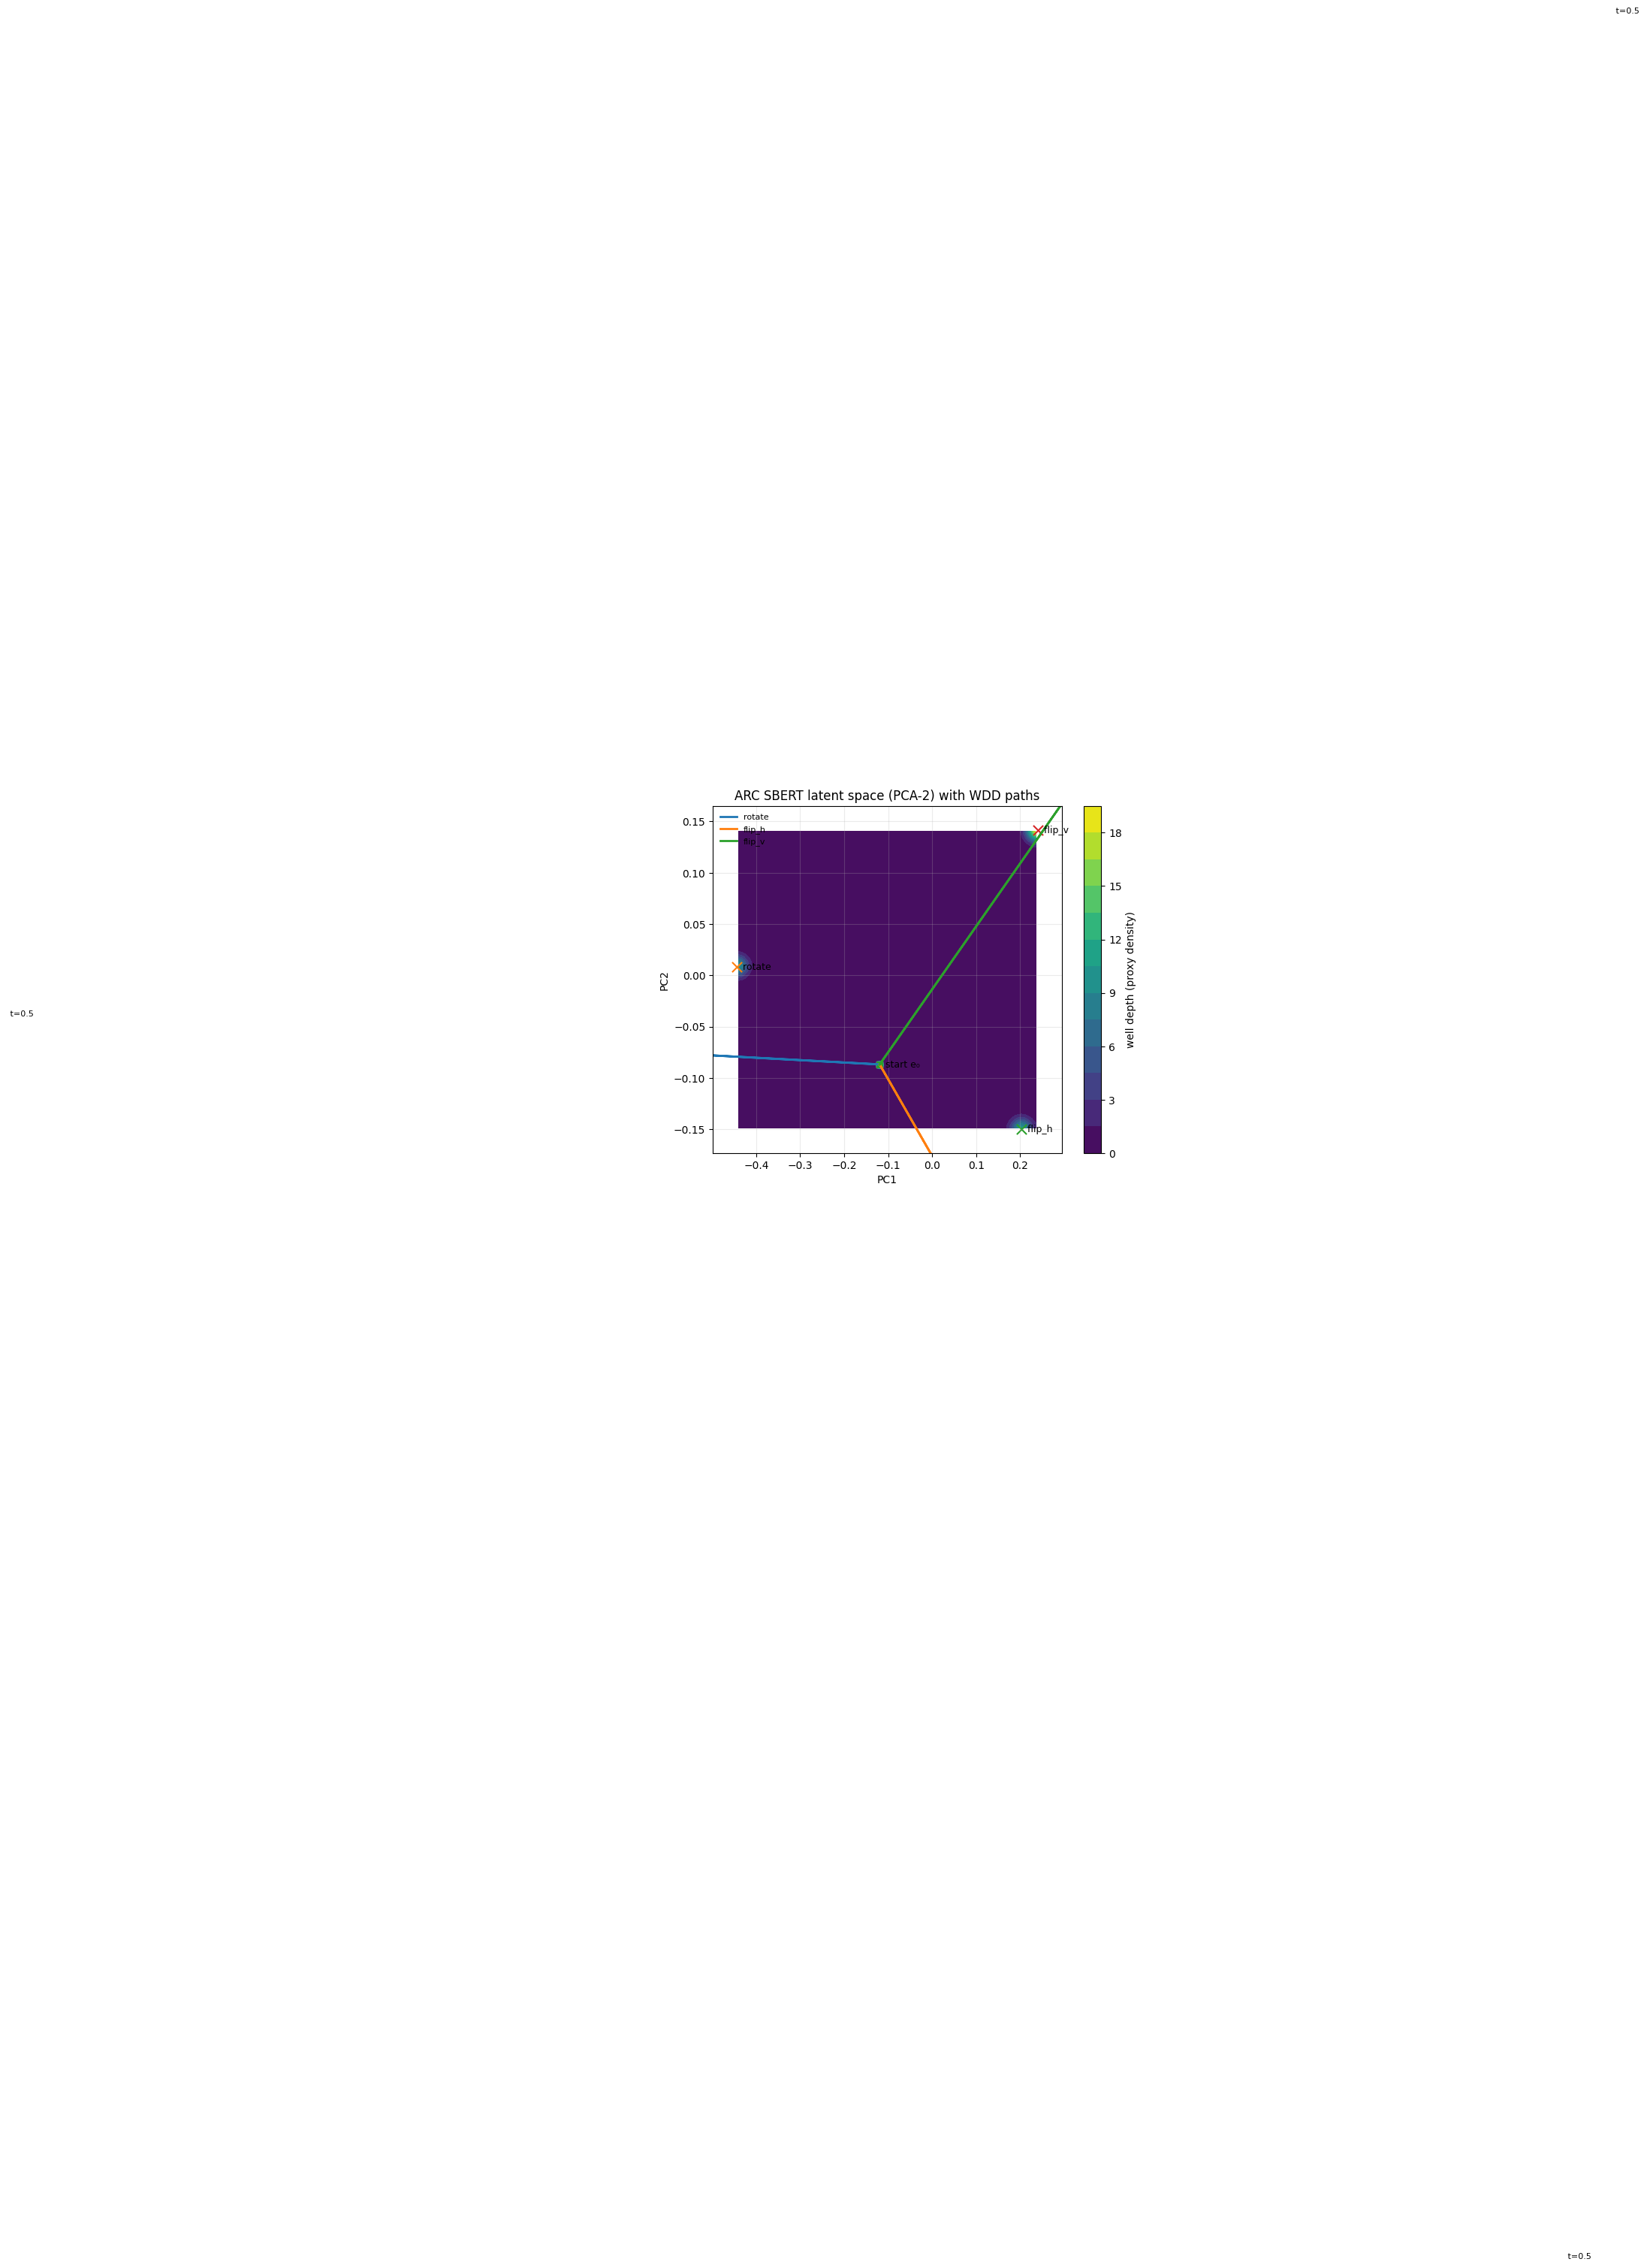

In [68]:
# === PCA-2 well with WDD paths, start dot, midpoint labels, and smoother bg ===
import os, numpy as np, joblib, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ----------------------- CONFIG ----------------------------------------------
ARC_MAPPER_PATH = ".artifacts/arc_mapper.joblib"
LATENTS_NPY     = "notebooks/research/arc_latents_post.npy"   # the same file you used for the well
PROMPT          = "rotate the grid 90 degrees clockwise, then flip it horizontally"
PATH_CLASSES    = ["rotate", "flip_h", "flip_v"]   # which prototype paths to draw

# background density tweaks
BINS   = 100       # try 80–140 if sample is small
SIGMA  = 2.5       # 2.0–3.0 gives a smooth well
Q_LOW, Q_HIGH = 0.01, 0.99   # crop quantiles
PAD    = 0.08      # % padding around the cropped extent

# WDD trace
TRACE_LEN  = 128
ALPHA_MAX  = 2.0

# ----------------------- minimal helpers -------------------------------------
def _normalize(v):
    v = np.asarray(v, float).reshape(-1)
    return v / (np.linalg.norm(v) + 1e-12)

def _unwrap_mapper(mapper):
    enc = None
    if hasattr(mapper, "named_steps"):
        for s in mapper.named_steps.values():
            if hasattr(s, "transform"):
                enc = s; break
    elif hasattr(mapper, "transform"):
        enc = mapper
    return enc

def _embed_texts(mapper, texts):
    enc = _unwrap_mapper(mapper)
    if enc is not None:
        return np.asarray(enc.transform(list(texts)))
    from sentence_transformers import SentenceTransformer
    m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return np.asarray(m.encode(list(texts), normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False))

ARC_CANON = {
    "rotate": "rotate the grid 90 degrees clockwise",
    "flip_h": "flip the grid horizontally",
    "flip_v": "flip the grid vertically",
    "recolor": "recolor blue cells to yellow",
    "color_map": "map blue cells to yellow",
}

def _proto_dirs_via_canon(mapper, classes):
    T = [ARC_CANON.get(c, c) for c in classes]
    E = _embed_texts(mapper, T)
    mu = _normalize(E.mean(axis=0))
    return {c: _normalize(E[i] - mu) for i, c in enumerate(classes)}

def _half_sine_path(e0, p_hat, T=TRACE_LEN, alpha_max=ALPHA_MAX):
    p = _normalize(p_hat)
    alphas = np.sin(np.linspace(0.0, np.pi, T)) * float(alpha_max)
    return e0[None,:] + alphas[:,None] * p[None,:]

# ----------------------- load corpus + PCA ------------------------------------
if not os.path.exists(LATENTS_NPY):
    raise FileNotFoundError(f"{LATENTS_NPY} not found — run the dump step first.")
X = np.load(LATENTS_NPY)
if X.ndim != 2:
    raise ValueError(f"{LATENTS_NPY} should be (N,D), got {X.shape}")

pca = PCA(n_components=2, random_state=0).fit(X)
Z = pca.transform(X)

# 2D histogram → gaussian-like blur
H, xedges, yedges = np.histogram2d(Z[:,0], Z[:,1], bins=BINS)
H = H.astype(float)
try:
    from scipy.ndimage import gaussian_filter
    Hs = gaussian_filter(H, sigma=SIGMA)
except Exception:
    # manual separable gaussian approx if scipy not available
    k = int(max(3, 6*SIGMA+1))
    t = np.arange(k) - (k-1)/2.0
    g = np.exp(-0.5*(t/SIGMA)**2); g /= g.sum()
    Hs = np.apply_along_axis(lambda r: np.convolve(r, g, mode='same'), axis=0, arr=H)
    Hs = np.apply_along_axis(lambda r: np.convolve(r, g, mode='same'), axis=1, arr=Hs)

# centers + padded extent so peaks don't hug frame
xc = 0.5*(xedges[:-1] + xedges[1:])
yc = 0.5*(yedges[:-1] + yedges[1:])
x_min, x_max = np.quantile(Z[:,0], [Q_LOW, Q_HIGH]); pad_x = PAD*(x_max - x_min)
y_min, y_max = np.quantile(Z[:,1], [Q_LOW, Q_HIGH]); pad_y = PAD*(y_max - y_min)
plt_xmin, plt_xmax = x_min - pad_x, x_max + pad_x
plt_ymin, plt_ymax = y_min - pad_y, y_max + pad_y

# ----------------------- WDD paths + centroids --------------------------------
mapper = joblib.load(ARC_MAPPER_PATH)

# class list only needed for proto dirs; canonical is fine for 3 classes
classes = PATH_CLASSES

Pdirs = _proto_dirs_via_canon(mapper, classes)
e0 = _normalize(_embed_texts(mapper, [PROMPT])[0])
e0_2d = pca.transform(e0.reshape(1,-1))[0]

# project canon "centroids" for labels
cent2 = {}
for c in classes:
    mu_c = _embed_texts(mapper, [ARC_CANON.get(c, c)])[0]
    cent2[c] = pca.transform(mu_c.reshape(1,-1))[0]

# build paths and project to PCA-2
paths2d = {}
for c in classes:
    Y = _half_sine_path(e0, Pdirs[c], TRACE_LEN, ALPHA_MAX)
    paths2d[c] = pca.transform(Y)

# ----------------------- plot -------------------------------------------------
fig, ax = plt.subplots(figsize=(7.5, 6.0))

# background density
cf = ax.contourf(xc, yc, Hs.T, levels=14)   # no explicit cmap → matplotlib default
ax.set_xlim(plt_xmin, plt_xmax); ax.set_ylim(plt_ymin, plt_ymax)
cb = fig.colorbar(cf, ax=ax, label="well depth (proxy density)")

# start marker for the prompt embedding e0
ax.scatter(e0_2d[0], e0_2d[1], s=50, marker='o')
ax.text(e0_2d[0], e0_2d[1], "  start e₀", fontsize=9, va='center')

# centroids (X) and labels
for c, (cx, cy) in cent2.items():
    ax.scatter([cx], [cy], s=90, marker='x')
    ax.text(cx, cy, f"  {c}", fontsize=9, va='center')

# WDD paths with midpoint markers/labels
for c, P2 in paths2d.items():
    ax.plot(P2[:,0], P2[:,1], linewidth=2, label=c)    # path polyline
    # start / mid / end markers
    ax.scatter(P2[0,0], P2[0,1], s=30, marker='o')
    mid = len(P2)//2
    ax.scatter(P2[mid,0], P2[mid,1], s=30, marker='^')
    ax.text(P2[mid,0], P2[mid,1], " t=0.5", fontsize=8, va='bottom', ha='left')
    ax.scatter(P2[-1,0], P2[-1,1], s=30, marker='s')

ax.set_title("ARC SBERT latent space (PCA-2) with WDD paths")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.grid(True, alpha=0.25); ax.legend(loc="best", fontsize=8, frameon=False)
plt.tight_layout()
out_png = "notebooks/research/arc_well_with_paths_v2.png"
plt.savefig(out_png, dpi=150)
print(f"Saved overlay figure to: {os.path.abspath(out_png)}")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1784: FutureWarning: `encoder_attention_mask` is d

Saved overlay figure to: /Users/ian_moore/repos/micro-lm/arc_well_with_paths.png


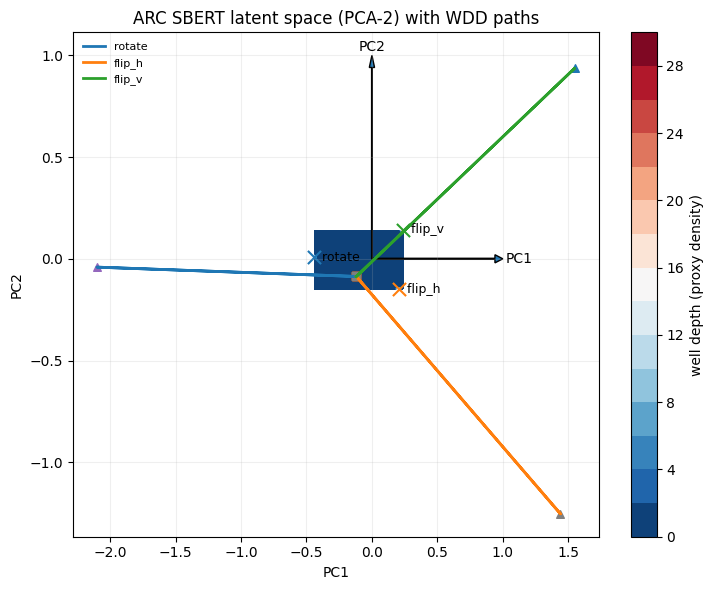

In [66]:
# === Overlay WDD latent paths on PCA-2 well ===================================
import os, numpy as np, joblib, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- CONFIG (edit) -----------------------------------------------------------
ARC_MAPPER_PATH = ".artifacts/arc_mapper.joblib"
ARC_LABELS_CSV  = ""  # optional (used only if you call centroid builder elsewhere)
LATENTS_NPY     = "notebooks/research/arc_latents_post.npy"   # the same file you used for the well
PROMPT          = "rotate the grid 90 degrees clockwise, then flip it horizontally"
PATH_CLASSES    = ["rotate", "flip_h", "flip_v"]     # which prototype paths to overlay
TRACE_LEN       = 128
ALPHA_MAX       = 2.0
BINS            = 120     # background density plot
SIGMA           = 2.0     # only used if scipy is available (nice blur)

# ---- Minimal helpers (robust fallbacks) --------------------------------------
def _normalize(v):
    v = np.asarray(v, float).reshape(-1)
    return v / (np.linalg.norm(v) + 1e-12)

def _unwrap_mapper(mapper):
    enc, clf = None, None
    if hasattr(mapper, "named_steps"):
        steps = list(mapper.named_steps.values())
        enc = next((s for s in steps if hasattr(s, "transform")), None)
        clf = steps[-1]
    else:
        enc = mapper if hasattr(mapper, "transform") else None
        clf = mapper if (hasattr(mapper, "predict_proba") or hasattr(mapper, "decision_function")) else None
    return enc, clf

def _get_classes(mapper):
    classes = None
    if hasattr(mapper, "named_steps"):
        classes = getattr(list(mapper.named_steps.values())[-1], "classes_", None)
    if classes is None:
        classes = getattr(mapper, "classes_", None)
    if classes is None:
        raise ValueError("Could not infer classes; set ARC_CLASS_NAMES earlier if needed.")
    if hasattr(classes, "tolist"):
        classes = classes.tolist()
    return [str(c) for c in classes]

def _embed_texts(mapper, texts):
    enc, _ = _unwrap_mapper(mapper)
    if enc is not None and hasattr(enc, "transform"):
        return np.asarray(enc.transform(list(texts)))
    from sentence_transformers import SentenceTransformer
    m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return np.asarray(m.encode(list(texts), normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False))

# canonical phrases (used if coef_/centroids aren’t available)
ARC_CANON = {
    "rotate": "rotate the grid 90 degrees clockwise",
    "flip_h": "flip the grid horizontally",
    "flip_v": "flip the grid vertically",
    "recolor": "recolor blue cells to yellow",
    "color_map": "map blue cells to yellow",
}

def _proto_directions_via_canon(mapper, class_names):
    T = [ARC_CANON.get(c, c) for c in class_names]
    E = _embed_texts(mapper, T)
    mu = _normalize(E.mean(axis=0))
    return {c: _normalize(E[i] - mu) for i, c in enumerate(class_names)}

def _half_sine_path(e0, p_hat, T=TRACE_LEN, alpha_max=ALPHA_MAX):
    p = _normalize(p_hat)
    alphas = np.sin(np.linspace(0.0, np.pi, T)) * float(alpha_max)
    return e0[None, :] + alphas[:, None] * p[None, :]

# ---- Load PCA corpus (same “post” set you plotted) ---------------------------
if not os.path.exists(LATENTS_NPY):
    raise FileNotFoundError(f"{LATENTS_NPY} not found — run the dump step that created arc_latents_post.npy first.")
X = np.load(LATENTS_NPY)           # shape (N, D)
if X.ndim != 2:
    raise ValueError(f"{LATENTS_NPY} should be (N,D); got {X.shape}")
# Fit PCA on this same corpus (equivalent to --fit_on post)
pca = PCA(n_components=2, random_state=0).fit(X)
Z = pca.transform(X)

# 2D background density (simple, fast) ----------------------------------------
# histogram → optional Gaussian blur (if scipy present) → contourf
H, xedges, yedges = np.histogram2d(Z[:,0], Z[:,1], bins=BINS)
try:
    from scipy.ndimage import gaussian_filter
    Hs = gaussian_filter(H.astype(float), sigma=SIGMA)
except Exception:
    Hs = H.astype(float)

# ---- Build WDD latent paths and project to PCA-2 -----------------------------
mapper = joblib.load(ARC_MAPPER_PATH)
classes = _get_classes(mapper)
Pdirs   = _proto_directions_via_canon(mapper, classes)   # swap in coef_/centroids if you have them

e0 = _normalize(_embed_texts(mapper, [PROMPT])[0])
paths2d = {}
for c in PATH_CLASSES:
    if c not in Pdirs: 
        continue
    Y = _half_sine_path(e0, Pdirs[c], TRACE_LEN, ALPHA_MAX)  # (T,D)
    paths2d[c] = pca.transform(Y)                             # (T,2)


# ---- Plot --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.5,6.0))
# contour background
Xc = 0.5*(xedges[:-1] + xedges[1:])
Yc = 0.5*(yedges[:-1] + yedges[1:])
cf = ax.contourf(Xc, Yc, Hs.T, levels=14, cmap="RdBu_r")

# overlay centroids (in PCA-2) for the classes we’re plotting
cent2 = {}
for c in PATH_CLASSES:
    if c in Pdirs:
        # crude centroid via canonical phrase
        mu_c = _embed_texts(mapper, [ARC_CANON.get(c, c)])[0]
        cent2[c] = pca.transform(mu_c.reshape(1,-1))[0]
        ax.scatter(cent2[c][0], cent2[c][1], s=90, marker="x")
        ax.text(cent2[c][0], cent2[c][1], f"  {c}", fontsize=9, va="center")

for c, P2 in paths2d.items():
    # mark start / mid / end along the path (t=0, 0.5, 1.0)
    T = len(P2)
    for t, m in [(0, "o"), (T//2, "^"), (T-1, "s")]:
        plt.scatter(P2[t,0], P2[t,1], s=30, marker=m)
        # optional tiny time label
        # plt.text(P2[t,0], P2[t,1], f" {t/(T-1):.1f}", fontsize=8)


# overlay paths
for c, P2 in paths2d.items():
    ax.plot(P2[:,0], P2[:,1], linewidth=2, label=c)
    ax.scatter(P2[0,0], P2[0,1], s=30, marker="o")  # start
    ax.scatter(P2[-1,0], P2[-1,1], s=30, marker="s") # end

# # draw PCA basis vectors in the PCA plane (centered at origin)
# import numpy as np
# origin = np.array([[0.0, 0.0]])
# # components_ is D×2 in original space; in PCA space those map to axis-aligned unit vectors
# # so just draw axis arrows for reference:
# plt.arrow(0, 0, 1, 0, width=0.005, head_width=0.04, length_includes_head=True)  # PC1 →
# plt.arrow(0, 0, 0, 1, width=0.005, head_width=0.04, length_includes_head=True)  # PC2 ↑
# plt.text(1.02, 0, "PC1", va="center"); plt.text(0, 1.02, "PC2", ha="center")

ax.set_title("ARC SBERT latent space (PCA-2) with WDD paths")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.grid(True, alpha=0.2); ax.legend(loc="best", fontsize=8, frameon=False)
fig.colorbar(cf, ax=ax, label="well depth (proxy density)")
plt.tight_layout()
out_png = "arc_well_with_paths.png"
plt.savefig(out_png, dpi=150)
print(f"Saved overlay figure to: {os.path.abspath(out_png)}")
plt.show()
